# 1. SETUP: IMPORTAR BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

# Configurações do notebook
warnings.filterwarnings('ignore', category=FutureWarning) # Ignorar avisos futuros do sklearn
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


# 2. CARREGAMENTO E PREPARAÇÃO DOS DADOS

In [ ]:
print("\n--- Carregando Dados ---")
# Fetch dataset
bike_sharing = fetch_ucirepo(id=275)

df = bike_sharing.data.original

print("\nColunas encontradas no DataFrame:")
print(df.columns)
print(f"\nDataset carregado. Formato: {df.shape}")
print(df.head())


--- Carregando Dados ---

Colunas encontradas no DataFrame:
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Dataset carregado. Formato: (17379, 17)
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  


# 3. EXPERIMENTO 1: Agrupando por Demanda (Casual vs. Registrado)


--- EXPERIMENTO 1: Agrupando por Demanda (Casual vs. Registrado) ---
Dados de demanda normalizados.
Executando Método do Cotovelo...


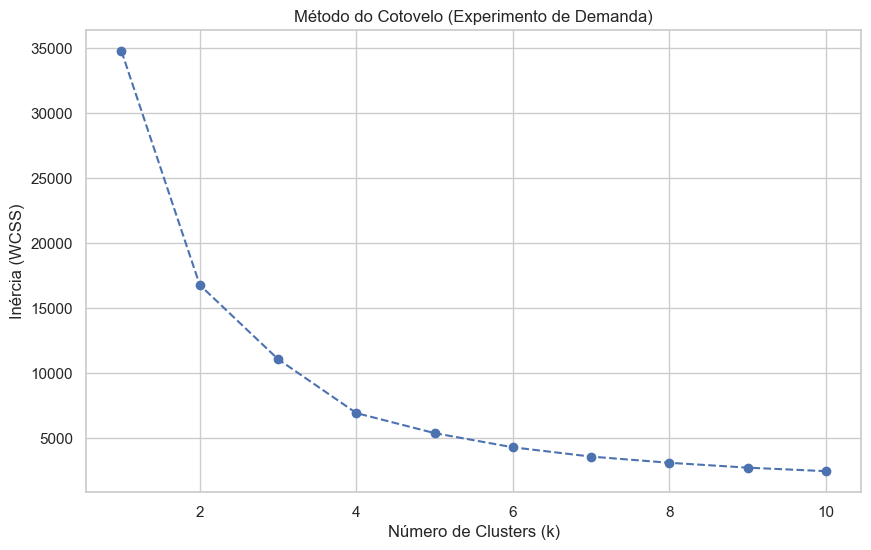


K-Means com k=4 executado.


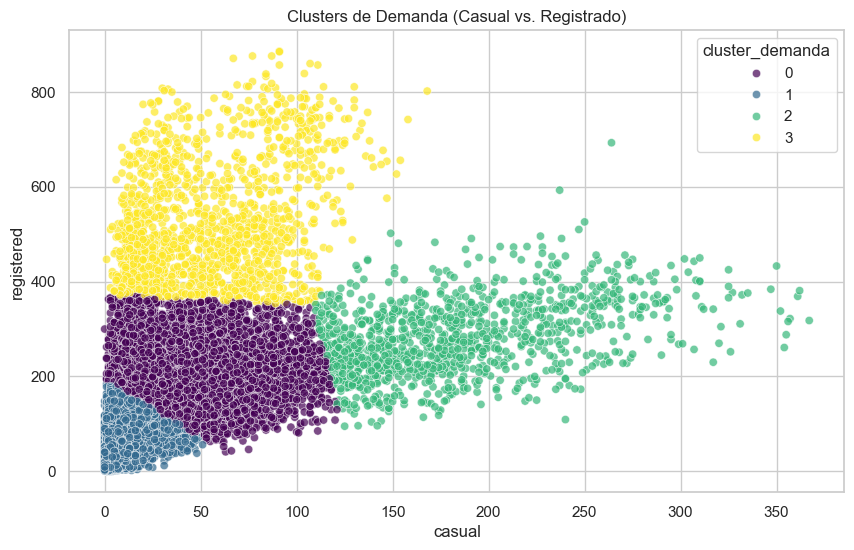

Centros dos Clusters de Demanda (Média por grupo):
       casual  registered
0   47.230853  202.885296
1    7.772801   50.619279
2  182.258348  281.164323
3   54.235978  520.964432

--- Testando k=2 (para Dia Útil vs. Fim de Semana) ---
Comparação: Cluster (k=2) vs. Dia Útil (workingday):
cluster_k2     0     1
workingday            
0           3890  1624
1           9100  2765

--- Validando k=4 (com Estação do Ano) ---
Comparação: Cluster (k=4) vs. Estação do Ano (season):
cluster_demanda     0     1    2    3
season                               
1                 807  3249   56  130
2                1533  2060  423  393
3                1784  1756  421  535
4                1420  2165  238  409


In [ ]:
print("\n--- EXPERIMENTO 1: Agrupando por Demanda (Casual vs. Registrado) ---")
features_demand = ['casual', 'registered']
data_demand = df[features_demand]

# Normalizar os dados (K-Means é sensível à escala)
scaler_demand = StandardScaler()
data_demand_scaled = scaler_demand.fit_transform(data_demand)

print("Dados de demanda normalizados.")

### Tarefa: Variar o número de grupos (Método do Cotovelo)
print("Executando Método do Cotovelo...")
inertia_list = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(data_demand_scaled)
    inertia_list.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_list, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Experimento de Demanda)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.grid(True)
plt.show()

# > Interpretação do Cotovelo: Analise o gráfico. O "cotovelo" (onde a taxa de
# > queda diminui) é um bom candidato para `k`. Vamos supor que `k=4` seja o ponto
# > escolhido.

### Rodando K-Means (Demanda) com k=4
k_demand = 4
kmeans_demand = KMeans(n_clusters=k_demand, init='k-means++', n_init=10, random_state=42)
kmeans_demand.fit(data_demand_scaled)

# Adicionar os clusters ao DataFrame principal
df['cluster_demanda'] = kmeans_demand.labels_

print(f"\nK-Means com k={k_demand} executado.")

### Visualização e Interpretação (Demanda)
# Visualizar os clusters
sns.scatterplot(data=df, x='casual', y='registered', hue='cluster_demanda', palette='viridis', alpha=0.7)
plt.title('Clusters de Demanda (Casual vs. Registrado)')
plt.show()

# Analisar os centros dos clusters (na escala original)
centers_demand = scaler_demand.inverse_transform(kmeans_demand.cluster_centers_)
centers_demand_df = pd.DataFrame(centers_demand, columns=features_demand)
print("Centros dos Clusters de Demanda (Média por grupo):")
print(centers_demand_df)

# > **Interpretação dos Centros:**
# > * Cluster 0: Baixo casual, Baixo registrado (Ex: Madrugada)
# > * Cluster 1: Baixo casual, Alto registrado (Ex: Dias de semana, hora do rush)
# > * Cluster 2: Alto casual, Alto registrado (Ex: Fim de semana de tempo bom)
# > * Cluster 3: Alto casual, Baixo registrado (Ex: Feriado, meio do dia)

### Tarefa: Testar com número de classes (Validação com suas ideias)

# Ideia: Fim de semana vs. Dia útil (k=2)
print("\n--- Testando k=2 (para Dia Útil vs. Fim de Semana) ---")
kmeans_k2 = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)
kmeans_k2.fit(data_demand_scaled)
df['cluster_k2'] = kmeans_k2.labels_

print("Comparação: Cluster (k=2) vs. Dia Útil (workingday):")
# 'workingday' == 1 (dia útil), 0 (fim de semana/feriado)
print(pd.crosstab(df['workingday'], df['cluster_k2']))

# > **Validação (k=2):** Veja se o Cluster 0 corresponde massivamente ao
# > `workingday=1` e o Cluster 1 ao `workingday=0`. Isso valida a ideia!

# Ideia: Estação do Ano (k=4)
print("\n--- Validando k=4 (com Estação do Ano) ---")
print("Comparação: Cluster (k=4) vs. Estação do Ano (season):")
# 'season' == 1 (inverno), 2 (primavera), 3 (verão), 4 (outono)
print(pd.crosstab(df['season'], df['cluster_demanda']))

# > **Validação (k=4):** Veja se algum cluster tem uma concentração alta
# > em uma estação. Ex: O cluster com "Alto casual" (Cluster 2 ou 3)
# > provavelmente terá mais instâncias na `season=3` (Verão).



# Grafico final de dispersão dos clusters

# Cluster 1 tem valores bem baixos nos dois tipos de usuários.
# Isso representa momentos em que poucas pessoas estavam usando as bicicletas — normalmente horários mais tranquilos, como madrugada ou clima ruim.

# Cluster 0 tem um pouco mais de usuários, principalmente registrados.
# Esse grupo representa momentos normais do dia, em que algumas pessoas usam, mas sem ser um horário muito cheio.

# Cluster 3 tem um valor muito alto de usuários registrados.
# Isso combina com horários de pico, quando muitas pessoas usam para ir trabalhar ou estudar.

# Cluster 2 tem valores altos tanto para casuais quanto para registrados.
# Esse é aquele momento em que o uso está alto geral — como finais de semana ensolarados, feriados ou horários bem movimentados.


# 4. EXPERIMENTO 2: Agrupando por Clima (Sua ideia)


--- EXPERIMENTO 2: Agrupando por Clima ---
Executando Método do Cotovelo para Clima...


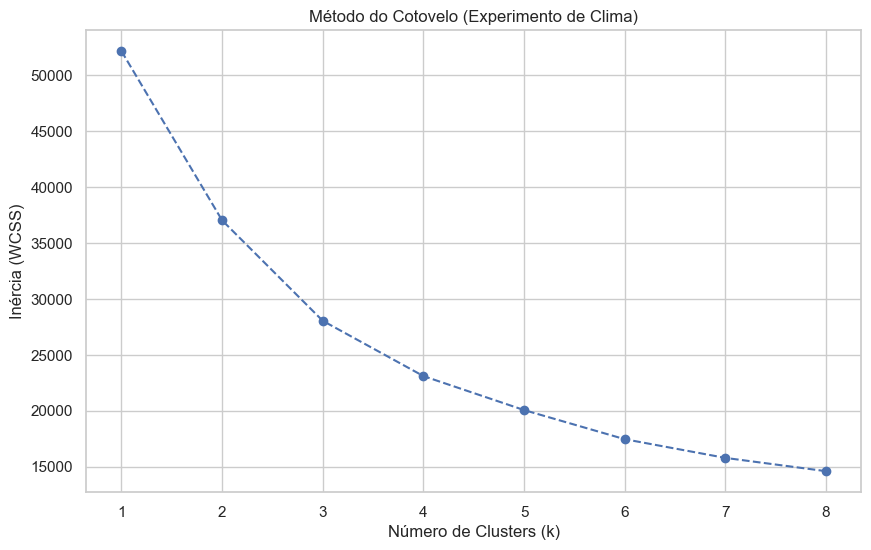


K-Means com k=3 executado.
Centros dos Clusters de Clima (Média por grupo):
       temp       hum  windspeed
0  0.703367  0.528486   0.199724
1  0.336722  0.484928   0.278705
2  0.456395  0.795719   0.122796

Média de Demanda (Total) por Cluster de Clima:
                      cnt     casual  registered
cluster_clima                                   
0              307.089589  72.394842  234.694747
1              157.065827  24.117432  132.948395
2              126.279009  16.937690  109.341318


In [4]:
print("\n--- EXPERIMENTO 2: Agrupando por Clima ---")
# Usamos 'temp' (temperatura), 'hum' (umidade), 'windspeed' (vento)
# 'atemp' é muito correlacionado com 'temp', então podemos deixar de fora.
features_climate = ['temp', 'hum', 'windspeed']
data_climate = df[features_climate]

# Normalizar
scaler_climate = StandardScaler()
data_climate_scaled = scaler_climate.fit_transform(data_climate)

### Método do Cotovelo (Clima)
print("Executando Método do Cotovelo para Clima...")
inertia_list_climate = []
k_range_climate = range(1, 9)

for k in k_range_climate:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(data_climate_scaled)
    inertia_list_climate.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range_climate, inertia_list_climate, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Experimento de Clima)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.grid(True)
plt.show()

# > **Interpretação do Cotovelo:** Vamos supor que `k=3` seja um bom
# > cotovelo (Ex: "Clima Bom", "Clima Médio", "Clima Ruim").

### Rodando K-Means (Clima) com k=3
k_climate = 3
kmeans_climate = KMeans(n_clusters=k_climate, init='k-means++', n_init=10, random_state=42)
kmeans_climate.fit(data_climate_scaled)

# Adicionar os clusters ao DataFrame
df['cluster_clima'] = kmeans_climate.labels_

print(f"\nK-Means com k={k_climate} executado.")

### Interpretação (Clima)
# Analisar os centros dos clusters
centers_climate = scaler_climate.inverse_transform(kmeans_climate.cluster_centers_)
centers_climate_df = pd.DataFrame(centers_climate, columns=features_climate)
print("Centros dos Clusters de Clima (Média por grupo):")
print(centers_climate_df)

# > **Interpretação dos Centros (Clima):**
# > * Um cluster terá 'temp' alta, 'hum' baixa/média (Clima Bom).
# > * Um cluster terá 'temp' baixa, 'hum' alta (Clima Ruim/Frio).
# > * Um cluster terá valores medianos.

# A GRANDE VALIDAÇÃO: Como a demanda (cnt) se comporta por cluster de clima?
print("\nMédia de Demanda (Total) por Cluster de Clima:")
print(df.groupby('cluster_clima')[['cnt', 'casual', 'registered']].mean().sort_values('cnt', ascending=False))

# > **Resultado:** Você deve ver que o cluster de "Clima Bom" tem a maior
# > média de `cnt` (total de aluguéis). Isso prova que o K-Means encontrou
# > padrões de clima que *realmente* impactam o negócio!


# 5. EXPERIMENTO 3: Agrupando por Hora do Dia (Sua ideia)


--- EXPERIMENTO 3: Agrupando por Padrão de Uso Horário ---
Executando Método do Cotovelo para Padrão Horário...


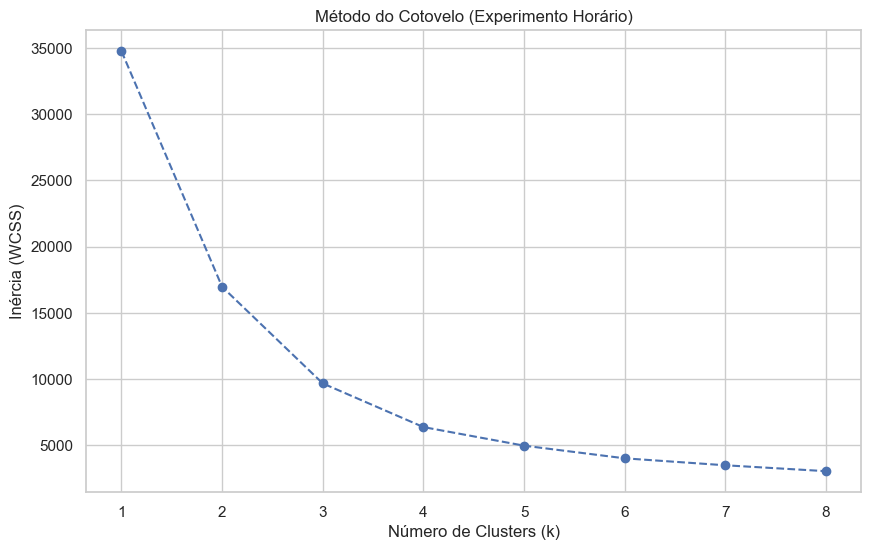


K-Means com k=4 executado.


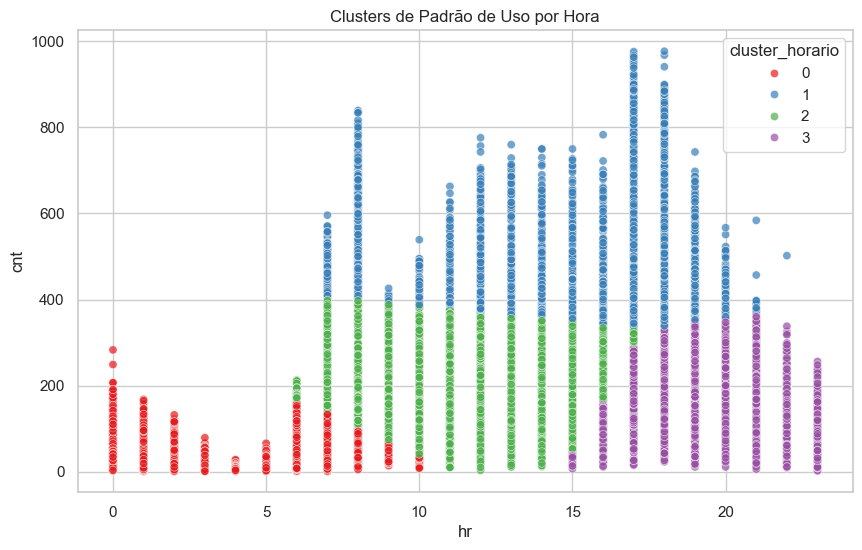

Centros dos Clusters de Horário (Média por grupo):
          hr         cnt
0   3.390556   32.975293
2  11.607959  203.226771
1  14.942143  520.147143
3  20.538959  152.405643


In [5]:
print("\n--- EXPERIMENTO 3: Agrupando por Padrão de Uso Horário ---")
# Usamos 'hr' (hora) e 'cnt' (demanda total)
features_hourly = ['hr', 'cnt']
data_hourly = df[features_hourly]

# Normalizar
scaler_hourly = StandardScaler()
data_hourly_scaled = scaler_hourly.fit_transform(data_hourly)

### Método do Cotovelo (Horário)
print("Executando Método do Cotovelo para Padrão Horário...")
inertia_list_hourly = []
k_range_hourly = range(1, 9)

for k in k_range_hourly:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(data_hourly_scaled)
    inertia_list_hourly.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range_hourly, inertia_list_hourly, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Experimento Horário)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.grid(True)
plt.show()

# > **Interpretação do Cotovelo:** Vamos tentar `k=4` para
# > (1) Madrugada, (2) Pico Manhã, (3) Meio do Dia, (4) Pico Tarde/Noite.

### Rodando K-Means (Horário) com k=4
k_hourly = 4
kmeans_hourly = KMeans(n_clusters=k_hourly, init='k-means++', n_init=10, random_state=42)
kmeans_hourly.fit(data_hourly_scaled)

# Adicionar os clusters ao DataFrame
df['cluster_horario'] = kmeans_hourly.labels_

print(f"\nK-Means com k={k_hourly} executado.")

### Interpretação (Horário)
# Visualizar os clusters
sns.scatterplot(data=df, x='hr', y='cnt', hue='cluster_horario', palette='Set1', alpha=0.7)
plt.title('Clusters de Padrão de Uso por Hora')
plt.show()

# Analisar os centros dos clusters
centers_hourly = scaler_hourly.inverse_transform(kmeans_hourly.cluster_centers_)
centers_hourly_df = pd.DataFrame(centers_hourly, columns=features_hourly)
print("Centros dos Clusters de Horário (Média por grupo):")
print(centers_hourly_df.sort_values(by='hr'))

# > **Interpretação:** O gráfico e os centros devem mostrar:
# > * Cluster 1: 'hr' baixa (ex: 0-5), 'cnt' baixo (Madrugada)
# > * Cluster 2: 'hr' média (ex: 7-9), 'cnt' alta (Pico Manhã)
# > * Cluster 3: 'hr' média (ex: 10-16), 'cnt' média (Meio do dia)
# > * Cluster 4: 'hr' alta (ex: 17-19), 'cnt' muito alta (Pico Tarde)


# 6. TAREFA 3: Explorar Outros Parâmetros (`init` e `n_init`)

In [6]:
print("\n--- EXPLORANDO PARÂMETROS (init e n_init) ---")
print("Usando k=4 no dataset de Demanda para comparar...")

# 1. Comparando init='k-means++' (inteligente) vs. init='random' (aleatório)
kmeans_pp = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
kmeans_pp.fit(data_demand_scaled)
print(f"\nInércia (WCSS) com init='k-means++': {kmeans_pp.inertia_}")

kmeans_random = KMeans(n_clusters=4, init='random', n_init=10, random_state=42)
kmeans_random.fit(data_demand_scaled)
print(f"Inércia (WCSS) com init='random':    {kmeans_random.inertia_}")

# > **Conclusão `init`:** 'k-means++' geralmente converge mais rápido
# > e leva a uma inércia final menor (ou igual) que 'random'.

# 2. Comparando n_init=10 (robusto) vs. n_init=1 (instável)
# n_init = Quantas vezes o algoritmo roda com centros iniciais diferentes.
kmeans_n10 = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
kmeans_n10.fit(data_demand_scaled)
print(f"\nInércia (WCSS) com n_init=10: {kmeans_n10.inertia_}")

kmeans_n1 = KMeans(n_clusters=4, init='k-means++', n_init=1, random_state=42)
kmeans_n1.fit(data_demand_scaled)
print(f"Inércia (WCSS) com n_init=1:  {kmeans_n1.inertia_}")

# Rodando n_init=1 com outra random_state para provar a instabilidade
kmeans_n1_b = KMeans(n_clusters=4, init='k-means++', n_init=1, random_state=123)
kmeans_n1_b.fit(data_demand_scaled)
print(f"Inércia (WCSS) com n_init=1 (outro seed): {kmeans_n1_b.inertia_}")


# > **Conclusão `n_init`:** Rodar com `n_init=1` é arriscado. Você pode
# > ter sorte e cair no mesmo resultado de `n_init=10`, ou pode ter azar
# > (como no 'outro seed') e ficar preso em um "ótimo local" (inércia maior).
# > `n_init=10` (o padrão) garante um resultado final muito mais robusto.


print("\n--- FIM DOS EXPERIMENTOS ---")


--- EXPLORANDO PARÂMETROS (init e n_init) ---
Usando k=4 no dataset de Demanda para comparar...

Inércia (WCSS) com init='k-means++': 6939.852397132634
Inércia (WCSS) com init='random':    6939.813863750331

Inércia (WCSS) com n_init=10: 6939.852397132634
Inércia (WCSS) com n_init=1:  6939.852397132633
Inércia (WCSS) com n_init=1 (outro seed): 6939.855928041994

--- FIM DOS EXPERIMENTOS ---
